<a href="https://colab.research.google.com/github/RianAbdul18/machine-learning_10222037/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:

!pip install pandas matplotlib seaborn wordcloud scikit-learn sastrawi -q

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("Semua library siap!")

Semua library siap!


In [46]:
print("="*90)
print("BUSINESS UNDERSTANDING")
print("="*90)
print("""
MASALAH BISNIS:
- Tokopedia menerima ribuan ulasan setiap hari.
- Ulasan negatif (rating 1-2) sering terlambat ditanggapi → turun rating toko.
- Ulasan netral (rating 3) sering diabaikan, padahal bisa jadi sinyal perbaikan.

TUJUAN PROYEK:
- Bangun model klasifikasi sentimen 3 kelas: Positif, Netral, Negatif.
- Input: teks ulasan
- Output: label sentimen

METRIK SUKSES:
- Accuracy ≥ 80%
- F1-Score per kelas (terutama Netral & Negatif)

MANFAAT:
- Penjual bisa tanggapi keluhan <24 jam
- Tokopedia tingkatkan kepuasan pelanggan
""")
print("="*90)

df = pd.read_csv('/content/tokopedia-product-reviews-2019.csv')
df = df[['text', 'rating']].copy()

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])
df['rating'] = df['rating'].astype(int)

print(f"Total data: {len(df):,} baris")
print("Contoh data:")
print(df.head())

BUSINESS UNDERSTANDING

MASALAH BISNIS:
- Tokopedia menerima ribuan ulasan setiap hari.
- Ulasan negatif (rating 1-2) sering terlambat ditanggapi → turun rating toko.
- Ulasan netral (rating 3) sering diabaikan, padahal bisa jadi sinyal perbaikan.

TUJUAN PROYEK:
- Bangun model klasifikasi sentimen 3 kelas: Positif, Netral, Negatif.
- Input: teks ulasan
- Output: label sentimen

METRIK SUKSES:
- Accuracy ≥ 80%
- F1-Score per kelas (terutama Netral & Negatif)

MANFAAT:
- Penjual bisa tanggapi keluhan <24 jam
- Tokopedia tingkatkan kepuasan pelanggan

Total data: 40,607 baris
Contoh data:
                                              text  rating
0           Barang sesuai pesanan dan cepat sampai       5
1                         Barang bagus harga murah       5
2  Paket rapi...mantap....cepat....sampe ke tujuan       5
3                       ya saya puas dgn barangnya       5
4                     Responya luar biasa b mantap       5



DATA UNDERSTANDING: Labeling & Distribusi Sentimen
Distribusi Sentimen:
sentiment
negatif      925
netral      1825
positif    37857
Name: count, dtype: int64

Persentase:
sentiment
positif    93.23
netral      4.49
negatif     2.28
Name: proportion, dtype: float64


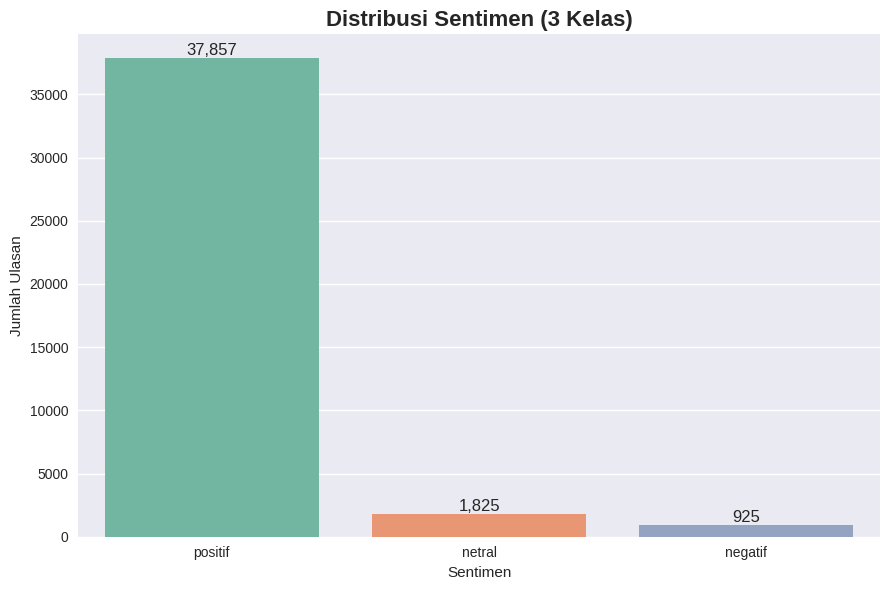

In [47]:
print("\n" + "="*70)
print("DATA UNDERSTANDING: Labeling & Distribusi Sentimen")
print("="*70)

# Buat label 3 kelas
def label_sentiment(rating):
    if rating >= 4: return 'positif'
    elif rating == 3: return 'netral'
    else: return 'negatif'

df['sentiment'] = df['rating'].apply(label_sentiment)

# Distribusi
print("Distribusi Sentimen:")
print(df['sentiment'].value_counts().sort_index())
print("\nPersentase:")
print((df['sentiment'].value_counts(normalize=True) * 100).round(2))

# Visualisasi
plt.figure(figsize=(9, 6))
ax = sns.countplot(data=df, x='sentiment', order=['positif', 'netral', 'negatif'], palette='Set2')
plt.title('Distribusi Sentimen (3 Kelas)', fontsize=16, fontweight='bold')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.tight_layout()
plt.show()


DATA PREPARATION: Whitelist → Stopword → Cleaning → Validasi
Total stopword: 159 kata

Membersihkan teks... (1-2 menit)
Data setelah cleaning: 38,471 baris
File disimpan: tokopedia_3kelas_prepared.csv

Membuat WordCloud perbandingan...


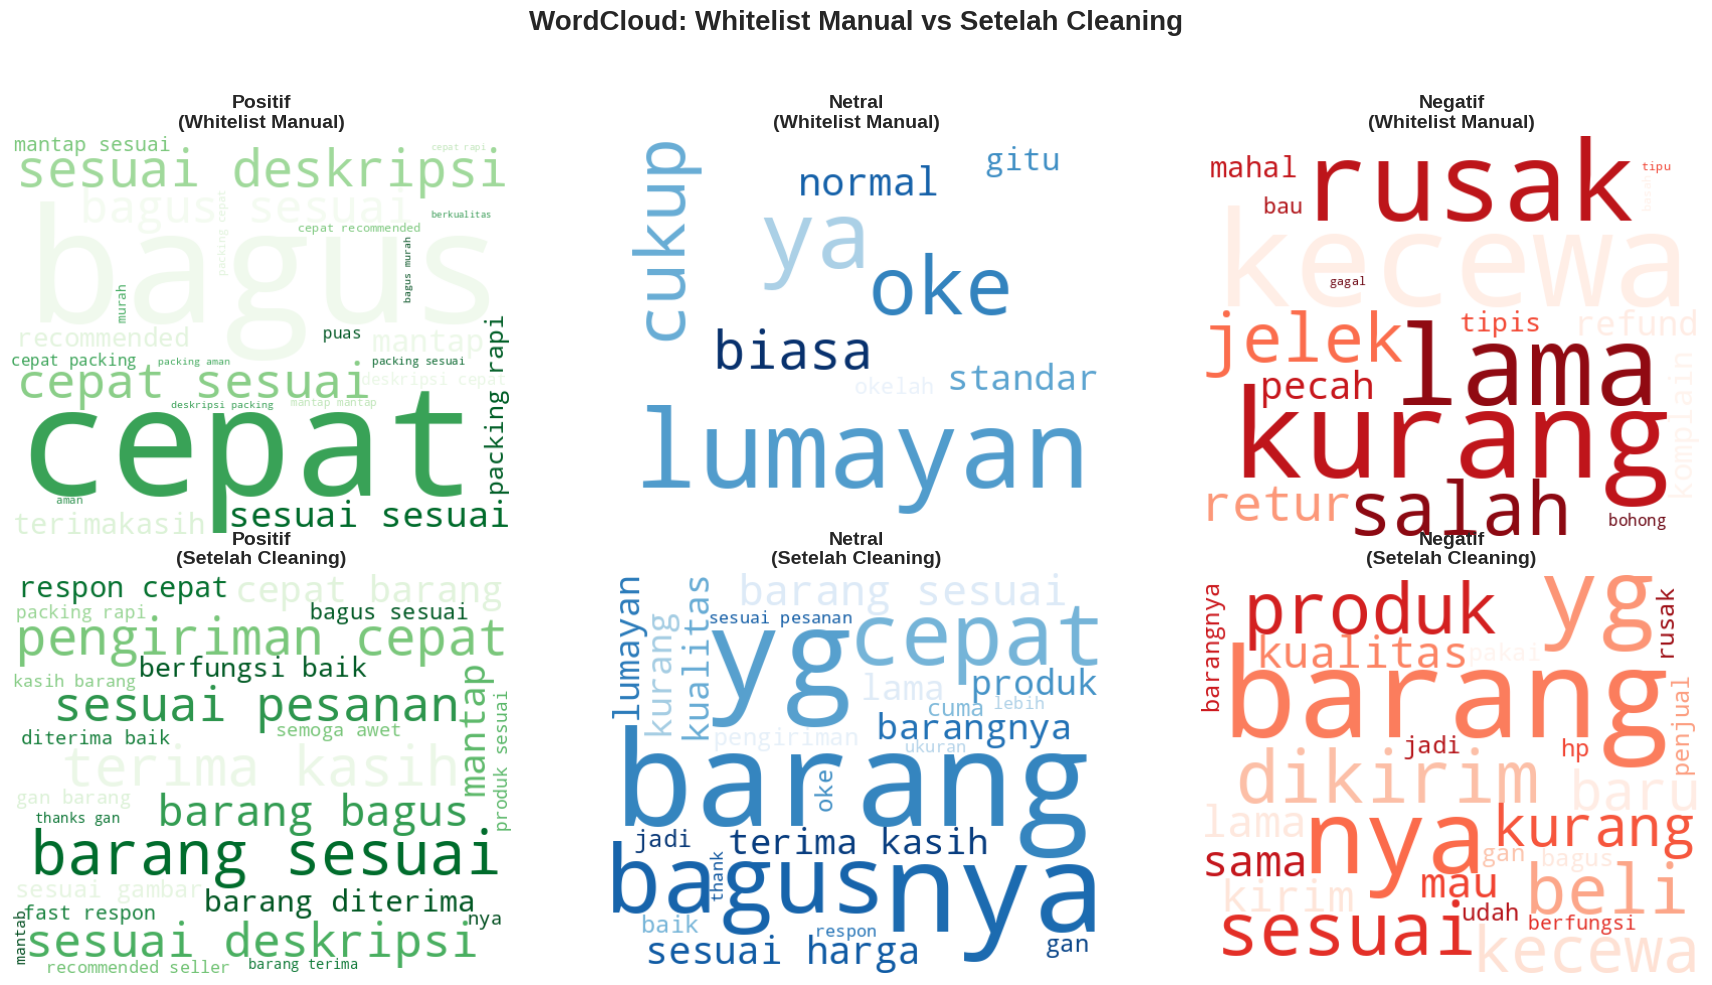


FREKUENSI KATA WHITELIST (SEBELUM CLEANING) - TOP 8

POSITIF  → 19 kata unik
  • sesuai         : 10,917 kali
  • cepat          : 8,677 kali
  • bagus          : 7,294 kali
  • mantap         : 2,838 kali
  • deskripsi      : 2,705 kali
  • packing        : 2,327 kali
  • rapi           : 1,585 kali
  • terimakasih    : 1,483 kali

NEGATIF  → 17 kata unik
  • kecewa         : 89 kali
  • kurang         : 75 kali
  • lama           : 61 kali
  • rusak          : 60 kali
  • salah          : 30 kali
  • jelek          : 26 kali
  • retur          : 25 kali
  • pecah          : 13 kali

NETRAL   → 9 kata unik
  • lumayan        : 130 kali
  • ya             : 93 kali
  • oke            : 67 kali
  • cukup          : 49 kali
  • biasa          : 26 kali
  • normal         : 12 kali
  • standar        : 10 kali
  • gitu           : 7 kali


In [48]:
print("\n" + "="*100)
print("DATA PREPARATION: Whitelist → Stopword → Cleaning → Validasi")
print("="*100)

whitelist = {
    'positif': ['bagus', 'cepat', 'mantap', 'puas', 'rekomendasi', 'rapi', 'aman', 'terbaik', 'suka', 'cinta', 'berkualitas', 'murah', 'recommended', 'terima kasih', 'terimakasih', 'packing', 'bubble', 'lengkap', 'sesuai', 'deskripsi'],
    'negatif': ['lama', 'rusak', 'tipis', 'kecewa', 'gagal', 'salah', 'kurang', 'jelek', 'mahal', 'bohong', 'tipu', 'refund', 'komplain', 'pecah', 'retur', 'batal', 'hilang', 'basah', 'bau'],
    'netral': ['biasa', 'lumayan', 'standar', 'okelah', 'cukup', 'biasa saja', 'ya', 'gitu', 'gitulah', 'oke', 'normal']
}

stopword_factory = StopWordRemoverFactory()
sastrawi_stopwords = stopword_factory.get_stop_words()
custom_stopwords = ['dan', 'di', 'ke', 'dari', 'yang', 'dengan', 'saya', 'ini', 'itu', 'adalah', 'untuk', 'pada', 'dg', 'dgn', 'd', 'kalo', 'kalau', 'ga', 'gak', 'gk', 'banget', 'bgt', 'nih', 'deh', 'si', 'aja', 'sih', 'dong', 'yah', 'ya', 'tdk', 'blm', 'bs', 'bisa', 'km', 'kmrn', 'dr', 'drpd', 'tp', 'tpi', 'krn', 'sm', 'smpai', 'smpe', 'utk', 'buat', 'dpt', 'blg', 'knp', 'kpn']
all_stopwords = list(set(sastrawi_stopwords + custom_stopwords))
print(f"Total stopword: {len(all_stopwords)} kata")

# FUNGSI CLEANING
stemmer = StemmerFactory().create_stemmer()
def clean_text_full(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'&[a-z]+;', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([w for w in text.split() if w not in all_stopwords])
    return text

# TERAPKAN CLEANING
print("\nMembersihkan teks... (1-2 menit)")
df['clean_text'] = df['text'].apply(clean_text_full)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 2].copy()
print(f"Data setelah cleaning: {len(df):,} baris")

# DATASET FINAL
df_final = df[['clean_text', 'sentiment']].copy().reset_index(drop=True)
df_final.to_csv('tokopedia_3kelas_prepared.csv', index=False)
print(f"File disimpan: tokopedia_3kelas_prepared.csv")

# WORDCLOUD: Whitelist vs Setelah Cleaning
print("\nMembuat WordCloud perbandingan...")

# Whitelist (sebelum)
data_before = {}
for sent in whitelist:
    texts = df[df['sentiment'] == sent]['text'].astype(str)
    full = " ".join(re.sub(r'[^a-z\s]', ' ', t.lower()) for t in texts)
    words = [w for w in full.split() if w in whitelist[sent]]
    data_before[sent] = " ".join(words) if words else "tidak ada kata"

# Setelah cleaning
data_after = {sent: " ".join(df_final[df_final['sentiment'] == sent]['clean_text']) for sent in ['positif', 'netral', 'negatif']}

# Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('WordCloud: Whitelist Manual vs Setelah Cleaning', fontsize=20, fontweight='bold', y=0.98)
colors = {'positif': 'Greens', 'netral': 'Blues', 'negatif': 'Reds'}

for idx, sent in enumerate(['positif', 'netral', 'negatif']):
    wc1 = WordCloud(width=500, height=400, background_color='white', colormap=colors[sent], max_words=25).generate(data_before[sent])
    axes[0, idx].imshow(wc1, interpolation='bilinear')
    axes[0, idx].set_title(f'{sent.capitalize()}\n(Whitelist Manual)', fontsize=14, fontweight='bold')
    axes[0, idx].axis('off')

    wc2 = WordCloud(width=500, height=400, background_color='white', colormap=colors[sent], max_words=25, stopwords=all_stopwords[:30]).generate(data_after[sent])
    axes[1, idx].imshow(wc2, interpolation='bilinear')
    axes[1, idx].set_title(f'{sent.capitalize()}\n(Setelah Cleaning)', fontsize=14, fontweight='bold')
    axes[1, idx].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

# FREKUENSI WHITELIST
print("\n" + "="*90)
print("FREKUENSI KATA WHITELIST (SEBELUM CLEANING) - TOP 8")
print("="*90)
for sent in whitelist:
    words = [w for t in df[df['sentiment'] == sent]['text'].astype(str).str.lower().tolist()
             for w in re.sub(r'[^a-z\s]', ' ', t).split() if w in whitelist[sent]]
    freq = Counter(words)
    print(f"\n{sent.upper():8} → {len(freq)} kata unik")
    for word, count in freq.most_common(8):
        print(f"  • {word:15}: {count:,} kali")
    if len(freq) == 0:
        print("  (tidak ditemukan)")
print("="*90)

In [49]:
print("\n" + "="*70)
print("DATA PREPARATION: Dataset Final")
print("="*70)

print(f"DATASET SIAP UNTUK MODELING!")
print(f"→ {len(df_final):,} baris")
print(f"→ Fitur: clean_text")
print(f"→ Label: sentiment (3 kelas)")
print("\nContoh 5 baris:")
print(df_final.head())

print("\nTUGAS SKKNI (BU → DU → DP) SUDAH SELESAI!")
print("Silakan screenshot grafik & tabel untuk PPTX.")


DATA PREPARATION: Dataset Final
DATASET SIAP UNTUK MODELING!
→ 38,471 baris
→ Fitur: clean_text
→ Label: sentiment (3 kelas)

Contoh 5 baris:
                             clean_text sentiment
0           barang sesuai pesanan cepat   positif
1              barang bagus harga murah   positif
2  paket rapi mantap cepat sampe tujuan   positif
3                        puas barangnya   positif
4          responya luar biasa b mantap   positif

TUGAS SKKNI (BU → DU → DP) SUDAH SELESAI!
Silakan screenshot grafik & tabel untuk PPTX.
